## Project 1

#### You've been hired by a new space weather startup looking to disrupt the space weather reporting business. 

#### Your first project is to provide better data about the top 50 solar flares recorded so far than that shown by your competitor.

### Part 1: Data scraping and preparation

#### Step 1: Scrape and format your competitor's data

#### Here I'm using requests and Beautiful Soup to get and parse data that put into a pandas dataframe

In [431]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

SpaceWeatherLiveUrl = 'https://www.spaceweatherlive.com/en/solar-activity/top-50-solar-flares'

SpaceWeatherResponse = requests.get(SpaceWeatherLiveUrl)
RawSpaceWeatherResponse = SpaceWeatherResponse.text

##Use BeautifulSoup to read and parse the data
RawSoup = BeautifulSoup(RawSpaceWeatherResponse)
##print(RawSoup.prettify())
##Use find() to save the data our salar flares table
RawTables = RawSoup.find_all('table')
##our table is the first one returned
RawTable = RawTables[0]
##print(RawTable)
##Use pandas to read in the HTML file
dfList = pd.read_html(str(RawTable), header=0)
##set the dataframe to the first item in the list
df = pd.DataFrame(dfList[0])
df.columns = ['rank','xClass','date','region','startTime','MaxTime','EndTime','movie']
##print(df)



C:\Users\madag\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\madag\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


### Step 2: Tidy the top 50 solar flare data

#### Make sure data is in a format pandas can use

#### Here I'm just doing data cleanup and formatting.

In [432]:
##drop movie column from the dataframe
newdf = df.drop('movie', axis=1)
##print(newdf)
##convert any date strings to datetimes
for index,row in enumerate(newdf.iterrows()):
    ##iterate through rows
    TheRow = pd.Series(row[1])
    TheDate = TheRow[2]
    TheStartDateTime = TheDate + ' ' + TheRow[4]
    TheRealStartDateTime = pd.to_datetime(TheStartDateTime)
    TheMaxDateTime = TheDate + ' ' + TheRow[5]
    TheRealMaxDateTime = pd.to_datetime(TheMaxDateTime)
    TheEndDateTime = TheDate + ' ' + TheRow[6]
    TheRealEndDateTime = pd.to_datetime(TheEndDateTime)
    ##replace the old string dates with datetime dates
    newdf.at[index,'startTime'] = TheRealStartDateTime
    newdf.at[index,'MaxTime'] = TheRealMaxDateTime
    newdf.at[index,'EndTime'] = TheRealEndDateTime
##drop the date column
newdf2 = newdf.drop('date', axis=1)
## no bad values for region...

In [433]:
##print(newdf2)

## Step 3: Scrape the NASA data

#### Here, as before, I'm using requests and beautiful soup to get and parse html data.  I took everything from the 'pre' tag and then used brute force to split this at the long series of =. then had to get rid of items that didn't belong.  Then I made a new dataframe with some columns I'll use later

In [434]:
##will need re later
import re
##and numpy too
import numpy as np

##NasaUrl = 'http://cdaw.gsfc.nasa.gov/CME_list/radio/waves_type2.html'
NasaUrl = 'http://www.hcbravo.org/IntroDataSci/misc/waves_type2.html'
##get the data
NasaResponse = requests.get(NasaUrl)
RawNasaResponse = NasaResponse.text

##Use BeautifulSoup to read and parse the data
RawNasaSoup = BeautifulSoup(RawNasaResponse)
##print(RawNasaSoup.prettify())
##Use find() to save the data our salar flares table
RawNasaData = RawNasaSoup.find_all('pre')
##all the data is in the first element of this list
##turn it into a string and extract what i need
RawStringParts = str(RawNasaData[0]).split('=================================================================================================')
##looks like the 3rd index in that list is what I want
LongTextString = RawStringParts[2]
##print(LongTextString)
##use line returns to split up the string into list of what will become rows
LongTextStringParts = LongTextString.split('\n')
##just keep the parts of the list that have content
LongTextStringParts2 = LongTextStringParts[1:483]
##print(LongTextStringParts2)
##store the cleaned up data here
CleanerData = []
for TheString in LongTextStringParts2:
    ##to extract the info i need, want to split each string everywhere there is <..>.  need regex
    ThePattern = '<.+?>'
    SplitString = re.split(ThePattern,TheString)
    #print(SplitString)
    ##some items contain info for multiple columns with spaces in between.  go through each item and find double,triple
    ##spaces and replace with a single splace.  then split the item and make a list of good,clean data
    CleanRow = []
    for item in SplitString:
        ##replace double,triple spaces with a single
        item.replace('  ',' ')
        item.replace('   ',' ')
        itemParts = item.split(' ')
        ##print(itemParts)
        ##if a part has a length, add it to the good, clean data
        ##----------if there is some missing data that fact won't be recorded---------------##
        for part in itemParts:
            if(len(part) > 0):
                CleanRow.append(part)
    ##if we have a full row, keep it
    if(len(CleanRow) == 15):
        CleanerData.append(CleanRow)
        ##print(CleanRow)
    ##for some data quality checking, print any rows of length<15.  handle missing data if necessary
    MissCount = 0
    if(len(CleanRow) < 15):
        MissCount = MissCount + 1
        print(CleanRow)
print('Number of used records: ',len(CleanerData))
print('Number of skipped records: ',MissCount)

##make a pandas dataframe for all this info
##first make list of column names
NasaFields = ['startDate','startTime','endDate','endTime','startFreq','endFreq','sourceLoc','NoaaReg','FlareImp','cmeDate','cmeTime','cpAngle','cmeWidth','cmeSpeed','plot']
RawNasaDf = pd.DataFrame.from_records(CleanerData,columns=NasaFields)
##later will need a field to know if a cmeWidth is a lower limit, default value is 0
zeroArray = np.zeros((len(CleanerData),), dtype=np.int)
##convert zeroArray to a list and add it to the data frame
RawNasaDf['isLowerLimit'] = zeroArray.tolist()
##also add empty columns for startDateTime,endDateTime,cmeDateTime
RawNasaDf['startDateTime'] = np.nan
RawNasaDf['endDateTime'] = np.nan
RawNasaDf['cmeDateTime'] = np.nan
##print(RawNasaDf)

Number of used records:  443
Number of skipped records:  0


C:\Users\madag\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\madag\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


## Step 4: Tidy the NASA table

#### Nasa missing data placeholders:
    startFreq,endFreq ???? 
    NoaaReg,sourceLoc,FlareImp ----
    cmeDate “LASCO DATA GAP” or other unspecified things
    cpAngle "Halo"
    cmeWidth Width = 360 means CME is a fill halo. sometimes there is “>” prefixed, which means reported width is a lower limit.
#### Combine date and time fields

#### Here I'm replacing bad/no data with NaN's or something similar and formatting data types

In [435]:
##clean this data
for index,row in enumerate(RawNasaDf.iterrows()):
    ##get the row as a pandas series
    TheRow = pd.Series(row[1])
    ##check the cpAngle value. if 'Halo' change to NA
    if(TheRow['cpAngle'] == 'Halo'):
        ##update the value
        RawNasaDf.at[index,'cpAngle'] = 'NA'
    ##now update row value with 'NaN' if value is not an int
    try:
        ##if value can be an int, keep it
        int(TheRow['NoaaReg'])
    except:
        ##if value can't be cast to int, replace with NaN
        RawNasaDf.at[index,'NoaaReg'] = 'NaN'
    ##do FlareImp
    if(TheRow['FlareImp'] == '----'):
        ##update the value
        RawNasaDf.at[index,'FlareImp'] = 'NaN'
    ##do sourceLoc
    if(TheRow['sourceLoc'] == 'BACK' or TheRow['FlareImp'] == 'Back' or TheRow['FlareImp'] == 'Back?'):
        ##update the value
        RawNasaDf.at[index,'sourceLoc'] = 'NaN'
    ##do startFreq
    if(TheRow['startFreq'] == '????'):
        ##update the value
        RawNasaDf.at[index,'startFreq'] = 'NaN'
    ##do endFreq
    if(TheRow['endFreq'] == '????'):
        ##update the value
        RawNasaDf.at[index,'endFreq'] = 'NaN'
    ##do cmeWidth
    ##here &gt; means >.  any value that can be split is a lower limit
    ##other values have non-numeric characters, also --- for NaN
    try:
        ##if value can be an int, keep it
        int(TheRow['cmeWidth'])
    except:
        ##if value can't be cast to int, see what kind of value it is and update it appropriately
        if(TheRow['cmeWidth'] == '---'):
            RawNasaDf.at[index,'cmeWidth'] = 'NaN'
        elif(TheRow['cmeWidth'].isdigit() == False):
            ##test for the >,update isLowerLimit if necessary
            if(len(TheRow['cmeWidth'].split(';')) > 1):
                WidthParts = TheRow['cmeWidth'].split(';')
                RawNasaDf.at[index,'isLowerLimit'] = 1
                RawNasaDf.at[index,'cmeWidth'] = WidthParts[1]
            elif(len(TheRow['cmeWidth'].split(';')) == 1):
                justInts = ''
                for character in TheRow['cmeWidth']:
                    if(WidthParts[0].isdigit()):
                        justInts = justInts + WidthParts[0]
                RawNasaDf.at[index,'cmeWidth'] = justInts
            else:
                print('I have not seen this before',TheRow['cmeWidth'])
        else:
            print('Don\'t know what to do with this',TheRow['cmeWidth'])
    ##now add in the the various combined datetime stamps
    ##lots of 24:00 values.  change to 00:00 before casting to datetime
    if(TheRow['startTime'] == '24:00'):
        startTime = '00:00'
    else:
        startTime = TheRow['startTime']
    StartDateTime = TheRow['startDate'] + ' ' + startTime
    ##the rest of the dates don\'t have a year, so have to append the year from here
    startDateParts = TheRow['startDate'].split('/')
    TheYear = startDateParts[0]
    ##print(TheYear)
    try:
        RealStartDateTime = pd.to_datetime(StartDateTime)
         ##assign to proper spot
        RawNasaDf.at[index,'startDateTime'] = RealStartDateTime
    except:
        print('this won\'t cast to date time: ',StartDateTime)
    
    ##lots of 24:00 values.  change to 00:00 before casting to datetime
    if(TheRow['cmeTime'] == '24:00'):
        cmeTime = '00:00'
    else:
        cmeTime = TheRow['cmeTime']
        
    CmeDateTime = TheYear + '/' + TheRow['cmeDate'] + ' ' + cmeTime
    try:
        RealCmeDateTime = pd.to_datetime(CmeDateTime)
         ##assign to proper spot
        RawNasaDf.at[index,'cmeDateTime'] = RealCmeDateTime
    except:
         print('this won\'t cast to date time: ',CmeDateTime) 
    
    ##lots of 24:00 values.  change to 00:00 before casting to datetime
    if(TheRow['endTime'] == '24:00'):
        endTime = '00:00'
    else:
        endTime = TheRow['endTime']
    EndDateTime = TheYear + '/' + TheRow['endDate'] + ' ' + endTime
    try:
        RealEndDateTime = pd.to_datetime(EndDateTime)
        ##assign to proper spot
        RawNasaDf.at[index,'endDateTime'] = RealEndDateTime
    except:
        print('this won\'t cast to date time: ',EndDateTime) 
                
##print(RawNasaDf)

this won't cast to date time:  2014/--/-- --:--


## Part 2: Analysis

### Replicate the top 50 solar flare table in SpaceWeatherLive.com exactly using the data obtained from NASA

#### According to Wikipedia (https://en.wikipedia.org/wiki/Solar_flare#Classification), solar flares can be ranked by their peak flux (watts per square meter) in the 100-800 picometer portion of the EM spectrum.

To attempt to replicate the table at SpaceWeatherLive.com, I'll rank the solar flares according to the 'Imp' column from the nasa website (http://cdaw.gsfc.nasa.gov/CME_list/radio/waves_type2.html)

#### Here I check the flare classification and use it to rank and sort the flares

In [436]:
##rank some data
##will use pandas.DataFrame.sort_values.  need two columns for sorting one for letter, one for number in 'FlareImp'
RawNasaDf['FlareImpLetter'] = 'NaN'
##print(RawNasaDf['FlareImpLetter'])
RawNasaDf['FlareImpNumber'] = np.nan
for index,row in enumerate(RawNasaDf.iterrows()):
    ##get the row as a pandas series
    TheRow = pd.Series(row[1])
    ##isolate the appropriate column
    TheRating = TheRow['FlareImp']
    ##check to see if there is a value to check
    if(TheRating[0] == 'A' or TheRating[0] == 'B' or TheRating[0] == 'C' or TheRating[0] == 'M' or TheRating[0] == 'X'):
        ImpLetter = TheRating[0]
        ImpNumber = TheRating[1:4]
        ##print(ImpNumber)
        ##assign to proper spots
        RawNasaDf.at[index,'FlareImpLetter'] = ImpLetter
        RawNasaDf.at[index,'FlareImpNumber'] = str(ImpNumber)
WholeSortedNasaDf = RawNasaDf.sort_values(by=['FlareImpLetter', 'FlareImpNumber'],ascending=False)
##WholeDateSortedNasaDf = RawNasaDf.sort_values(by=['startDate'],ascending=False)
SortedNasaDf = WholeSortedNasaDf[0:50]
##print(SortedNasaDf)
##DateSortedNasaDf = SortedNasaDf.sort_values(by=['startDate'],ascending=False)

### Write a function that finds the best matching row in the NASA data for each of the top 50 solar flares in the SpaceWeatherLive data.

#### I'll look at the top 50 from each dataset.  They won't all match, so giving each row in the nasa dataset a ranking would be misleading for anyone looking at these results.  Based on my analysis(completed in October 2017), the two data sets have 18 unique start dates that only appear in one data set or the other.  

#### I'll create keys for each data set to uniquely identify each row.  I'll do a long key(start day,region,full flare importance classification) that corresponds to a high confidence match.  I'll do a short key(start day, numeric portion of the flare importance classification) for likely matches.  When the keys match I'll put a space weather rank in the nasa data. 

#### First I'll insert ranks based on the short key.  Then I'll do the same with the long key.  If no match, the column will be None.

In [437]:
##give space weather data frame a more useful name
SpaceWeatherDf = newdf2
##add another column to the SortedNasaDf for the space weather rank
##SortedNasaDf['SpaceWeatherRank'] = np.nan
RankValues = [None] * 50

##print(SortedNasaDf)
##look for matches
##keep hits in these sets
LongKeySet = set()
ShortKeySet = set()
NasaDateSet = set()
SpaceWeatherDateSet = set()

##for each row in the nasa data look through the space weather data for a match
for index,row in enumerate(SortedNasaDf.iterrows()):
    ##get the row as a pandas series
    TheRow = pd.Series(row[1])
    ##print(TheRow['startDate'])
    ##print('at row ' + str(index))
    ##get the start date,region,FlareImpLetter,FlareImpNumber
    TheDay = str(TheRow['startDateTime'])[0:10]
    NasaDateSet.add(TheDay)
    TheRegion = TheRow['NoaaReg']##make sure to get region in format to match space weather
    if(len(TheRegion) == 5):
        TheRegion = TheRow['NoaaReg'][2:5]
    TheImpLetter = TheRow['FlareImpLetter']
    TheImpNumber = TheRow['FlareImpNumber']
    NasaKey = TheDay + '_' + str(TheRegion) + '_' + TheImpLetter + '_' + str(TheImpNumber)[0:4]
    NasaShortKey = TheDay + '_' + str(TheImpNumber)[0:4]
    
    ##now go through space weather data and check for matches
    for SwIndex,SwRow in enumerate(SpaceWeatherDf.iterrows()):
        ##get the row as a pandas series
        TheSwRow = pd.Series(SwRow[1])
        ##get things for comparing
        TheSwDay = str(TheSwRow['startTime'])[0:10]
        ##add to the appropriate set
        SpaceWeatherDateSet.add(TheSwDay)
        TheSwRegion = TheSwRow['region']
        TheSwImpLetter = TheSwRow['xClass'][0]
        TheSwImpNumber = TheSwRow['xClass'][1:5]
        SwKey = TheSwDay + '_' + str(TheSwRegion) + '_' + TheSwImpLetter + '_' + str(TheSwImpNumber)[0:4]
        SwShortKey = TheSwDay + '_' + str(TheSwImpNumber)[0:4]
        
        ##use short key to update
        if(NasaShortKey == SwShortKey):
            ##add to the appropriate set
            ShortKeySet.add(SwShortKey)
            ##SortedNasaDf.at[index,'SpaceWeatherRank'] = TheSwRow['rank']
            ##print('short key update at ' + str(index))
            RankValues[index] = (str(TheSwRow['rank']))
        ##if the long key matches, use it instead
        if(NasaKey == SwKey):
            ##add to the appropriate set
            LongKeySet.add(SwKey)
            ##SortedNasaDf.at[index,'SpaceWeatherRank'] = TheSwRow['rank']
            ##print('long key update at ' + str(index))
            RankValues[index] = (str(TheSwRow['rank']))

##see if there is really any hope in matching all 50 based on event start dates
print('There are ' + str(len(NasaDateSet)) + ' unique dates in the Nasa data')
print('There are  ' + str(len(SpaceWeatherDateSet)) + ' unique dates in the space weather data')
print('The two data sets share ' + str(len(NasaDateSet&SpaceWeatherDateSet)) + ' unique start dates')
print('The two data sets have ' + str(len(NasaDateSet-SpaceWeatherDateSet)) + ' unique start dates that only appear in one data set or the other.')

##SortedRankedNasaDf = SortedNasaDf.sort_values(by=['SpaceWeatherRank'],ascending=True)
##print(SortedRankedNasaDf)
##print(RankValues)
##add the ranks for rows that have them
SortedNasaDf['SpaceWeatherRank'] = RankValues
##print(SortedNasaDf)

There are 46 unique dates in the Nasa data
There are  47 unique dates in the space weather data
The two data sets share 28 unique start dates
The two data sets have 18 unique start dates that only appear in one data set or the other.


C:\Users\madag\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Prepare one plot that shows the top 50 solar flares in context with all data available in the NASA dataset

#### I made a time series of count of flares per month showing top 50 flares.  It does seem to show clusters of significant events.  Periods of time with increased activity stands out.

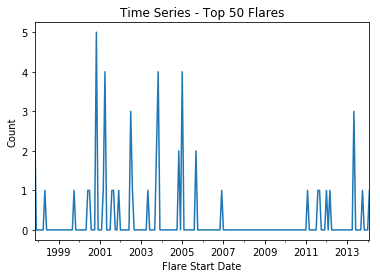

In [439]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

##df for plotting
PlotDf = SortedNasaDf[['startDateTime','FlareImpNumber']].copy()
##print(PlotDf)
PlotDf.index = PlotDf['startDateTime']
del PlotDf['startDateTime']
##print(PlotDf)
PlotDf.resample('M').count().plot(legend=None)
plt.ylabel('Count')
plt.xlabel('Flare Start Date')
plt.title('Time Series - Top 50 Flares')
plt.show()